# Contents
* [data](#data)
* [transfer](#transfer)

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm

plt.ion() 

#### data

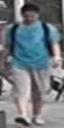

In [2]:
data = np.array(glob('data/Market-1501-v15.09.15/bounding_box_train/*.jpg'))
img0 = Image.open(data[0])
img0

In [3]:
data_cl = np.array([int(x.split('/')[-1].split('_')[0]) for x in data])
np.unique(data_cl).shape

(751,)

In [4]:
train, test, train_cl, test_cl = train_test_split(data, data_cl, test_size=0.1, random_state=18, stratify=data_cl)
train_cl.shape, test_cl.shape, np.unique(train_cl).shape, np.unique(test_cl).shape

((11642,), (1294,), (751,), (693,))

In [5]:
'''folder = 'data2/market/train/'

for img in tqdm(train):
    name = img.split('/')[-1]
    directory = name.split('_')[0]
    directory = '%s%s' % (folder, directory)
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    Image.open(img).save('%s/%s' % (directory, name))'''

"folder = 'data2/market/train/'\n\nfor img in tqdm(train):\n    name = img.split('/')[-1]\n    directory = name.split('_')[0]\n    directory = '%s%s' % (folder, directory)\n    \n    if not os.path.exists(directory):\n        os.makedirs(directory)\n    \n    Image.open(img).save('%s/%s' % (directory, name))"

In [6]:
'''folder = 'data2/market/test/'

for img in tqdm(test):
    name = img.split('/')[-1]
    directory = name.split('_')[0]
    directory = '%s%s' % (folder, directory)
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    Image.open(img).save('%s/%s' % (directory, name))'''

"folder = 'data2/market/test/'\n\nfor img in tqdm(test):\n    name = img.split('/')[-1]\n    directory = name.split('_')[0]\n    directory = '%s%s' % (folder, directory)\n    \n    if not os.path.exists(directory):\n        os.makedirs(directory)\n    \n    Image.open(img).save('%s/%s' % (directory, name))"

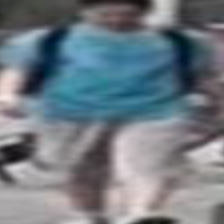

In [7]:
Валерияtr = transforms.Compose([
        transforms.Scale((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip()
    ])

tr(img0)

#### transfer

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Scale([256, 256]),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Scale([256, 256]),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'data2/market/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloders = {x[0]: torch.utils.data.DataLoader(image_datasets[x[0]], batch_size=x[1],
                                             shuffle=True, num_workers=4)
              for x in [('train', 64), ('test', 4)]}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [17]:
list(dataloders['test'])[0][1]


 387
 311
 545
 109
[torch.LongTensor of size 4]

In [7]:
dataset_sizes

{'test': 1294, 'train': 11642}

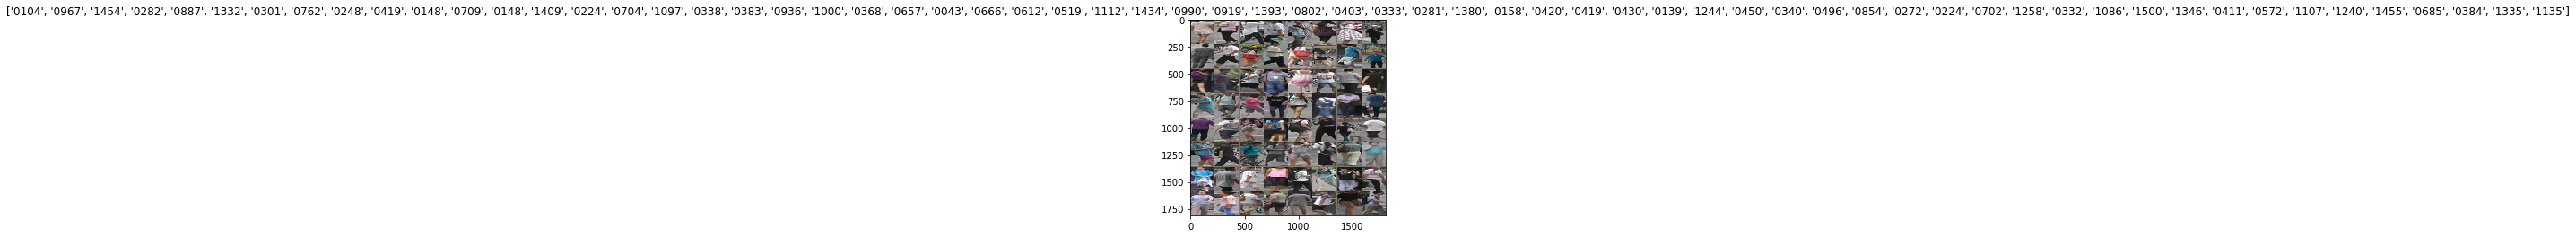

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for data in dataloders[phase]:
                inputs, labels = data

                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                print('better')
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    #model.load_state_dict(best_model_wts)
    return model

In [63]:
model_ft = models.resnet50(pretrained=True)

for param in model_ft.parameters():
    param.requires_grad = False
    
num_ftrs = model_ft.fc.in_features
model_ft.fc = torch.nn.Sequential()
model_ft.fc.add_module('dropout', torch.nn.Dropout(p=0.75))
model_ft.fc.add_module('fc1', nn.Linear(num_ftrs, 751))

if use_gpu:
    model_ft = model_ft.cuda()
    
model_ft

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): Bottleneck (
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (downsample): Sequential (
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
    )
    (1): Bott

In [64]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.002, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [65]:
model_conv = train_model(model_ft, criterion, optimizer_ft,
                         exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss: 0.1042 Acc: 0.0055
test Loss: 1.6924 Acc: 0.0039
better

Epoch 1/14
----------
train Loss: 0.1009 Acc: 0.0119
test Loss: 1.7025 Acc: 0.0046
better

Epoch 2/14
----------
train Loss: 0.0985 Acc: 0.0234
test Loss: 1.7061 Acc: 0.0023

Epoch 3/14
----------
train Loss: 0.0966 Acc: 0.0334
test Loss: 1.7097 Acc: 0.0062
better

Epoch 4/14
----------
train Loss: 0.0945 Acc: 0.0449
test Loss: 1.7080 Acc: 0.0070
better

Epoch 5/14
----------
train Loss: 0.0927 Acc: 0.0561
test Loss: 1.7090 Acc: 0.0070

Epoch 6/14
----------
train Loss: 0.0908 Acc: 0.0667
test Loss: 1.7111 Acc: 0.0039

Epoch 7/14
----------
train Loss: 0.0894 Acc: 0.0734
test Loss: 1.7104 Acc: 0.0046

Epoch 8/14
----------
train Loss: 0.0890 Acc: 0.0758
test Loss: 1.7103 Acc: 0.0062

Epoch 9/14
----------
train Loss: 0.0887 Acc: 0.0799
test Loss: 1.7086 Acc: 0.0054

Epoch 10/14
----------
train Loss: 0.0887 Acc: 0.0788
test Loss: 1.7097 Acc: 0.0070

Epoch 11/14
----------
train Loss: 0.0886 Acc: 

In [66]:
#torch.save(model_conv, 'finetuned_fc_lr_002_7_1_resnet_market_2.pt')

In [47]:
model_conv = torch.load('finetuned_fc_lr_002_7_1_resnet_market_2.pt')

In [67]:
for param in model_conv.parameters():
    param.requires_grad = True

In [68]:
params_dict = dict(model_conv.named_parameters())
params = []
for key, value in params_dict.items():
    print(key)
    if ('conv1' in key) & (not 'layer' in key):
        params += [{'params':[value],'lr':0.00001}]
    elif ('conv' in key):# | ('fc1' in key):
        params += [{'params':[value],'lr':0.002}]
    elif ('fc1' in key):
        params += [{'params':[value],'lr':0.1}]
    elif 'bias' in key:
        params += [{'params':[value], 'lr':0.0001, 'weight_decay':0}]
    else:
        params += [{'params':[value], 'lr':0.0001}] #'weight_decay':0.0001

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [69]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(params, momentum=0.9, weight_decay=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=40, gamma=0.1)

In [70]:
model_conv = train_model(model_conv, criterion, optimizer_ft,
                         exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1503970438496/work/torch/lib/THC/generic/THCStorage.cu:66

In [40]:
model_ft = train_model(model_conv, criterion, optimizer_ft,
                         exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.0802 Acc: 0.1836
test Loss: 2.9901 Acc: 0.0124
better

Epoch 1/49
----------
train Loss: 0.0449 Acc: 0.4164
test Loss: 3.6431 Acc: 0.0093

Epoch 2/49
----------
train Loss: 0.0292 Acc: 0.5737
test Loss: 4.0075 Acc: 0.0108

Epoch 3/49
----------
train Loss: 0.0206 Acc: 0.6814
test Loss: 4.6710 Acc: 0.0124

Epoch 4/49
----------
train Loss: 0.0151 Acc: 0.7519
test Loss: 4.9949 Acc: 0.0170
better

Epoch 5/49
----------
train Loss: 0.0113 Acc: 0.8037
test Loss: 5.1467 Acc: 0.0139

Epoch 6/49
----------


Process Process-125:
KeyboardInterrupt
Process Process-128:
Process Process-127:
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt: 

  File "/home/lera/.conda/envs/reid/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/lera/.conda/envs/reid/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process Process-126:
  File "/home/lera/.conda/envs/reid/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lera/.conda/envs/reid/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/lera/.conda/envs/reid/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/home/lera/.conda/envs/reid/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/home/lera/.conda/envs/reid/lib/python3.6/multiprocessing/queues.py", line 342, in get
    res = self._reader.recv_bytes()

In [ ]:
torch.save(model_conv, 'finetuned_with_fc_resnet_market_2.pt')

In [ ]:
# without finetuning last layer

In [63]:
model_ft = train_model(model_ft, criterion, optimizer_ft,
                         exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.0464 Acc: 0.3773
test Loss: 2.2389 Acc: 0.0116
better

Epoch 1/49
----------
train Loss: 0.0330 Acc: 0.5400
test Loss: 2.4191 Acc: 0.0124
better

Epoch 2/49
----------
train Loss: 0.0263 Acc: 0.6348
test Loss: 2.5378 Acc: 0.0116

Epoch 3/49
----------
train Loss: 0.0217 Acc: 0.7009
test Loss: 2.6193 Acc: 0.0108

Epoch 4/49
----------
train Loss: 0.0181 Acc: 0.7523
test Loss: 2.6868 Acc: 0.0116

Epoch 5/49
----------
train Loss: 0.0152 Acc: 0.7918
test Loss: 2.7412 Acc: 0.0131
better

Epoch 6/49
----------
train Loss: 0.0131 Acc: 0.8269
test Loss: 2.8197 Acc: 0.0116

Epoch 7/49
----------
train Loss: 0.0112 Acc: 0.8563
test Loss: 2.8780 Acc: 0.0147
better

Epoch 8/49
----------
train Loss: 0.0098 Acc: 0.8779
test Loss: 2.9379 Acc: 0.0139

Epoch 9/49
----------
train Loss: 0.0085 Acc: 0.8985
test Loss: 2.9756 Acc: 0.0139

Epoch 10/49
----------
train Loss: 0.0073 Acc: 0.9132
test Loss: 3.0561 Acc: 0.0139

Epoch 11/49
----------
train Loss: 0.0065 Acc: 

In [69]:
torch.save(model_ft, 'finetuned_resnet_market.pt')

In [101]:
model2 = torch.load('finetuned_resnet_market.pt')

In [95]:
model_cpu = model_ft.cpu()
model_cpu

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): Bottleneck (
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (downsample): Sequential (
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
    )
    (1): Bott

In [96]:
torch.save(model_cpu, 'finetuned_resnet_market_cpu.pt')

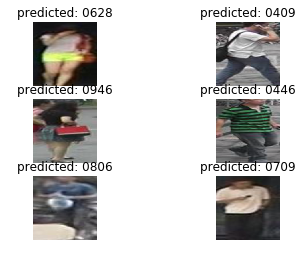

In [68]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloders['test']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return
            
visualize_model(model_conv)

plt.ioff()
plt.show()

data/Market-1501-v15.09.15/bounding_box_train/0281_c2s1_061496_01.jpg


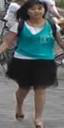

In [74]:
print(test[0])
img = Image.open(test[0])
img

In [88]:
inputs, classes = next(iter(dataloders['test']))
inputs


( 0 , 0 ,.,.) = 
  0.2282  0.1939  0.1768  ...  -1.0219 -1.0562 -1.0219
  0.1597  0.1597  0.1597  ...  -1.1247 -1.1589 -1.1418
 -0.3369 -0.3027 -0.2684  ...  -0.9877 -1.0733 -1.1075
           ...             ⋱             ...          
 -0.5596 -0.5767 -0.5767  ...   1.0844  1.0502  1.0331
 -0.5424 -0.5596 -0.5596  ...   0.5878  0.4679  0.3823
 -0.5938 -0.5938 -0.5938  ...   0.0398 -0.0629 -0.1486

( 0 , 1 ,.,.) = 
  0.2927  0.2752  0.2752  ...  -0.8803 -0.8978 -0.8803
  0.2052  0.2227  0.2227  ...  -1.0203 -1.0553 -1.0378
 -0.3200 -0.2850 -0.2500  ...  -0.8978 -1.0028 -1.0203
           ...             ⋱             ...          
 -0.5301 -0.5476 -0.5476  ...   0.7829  0.7829  0.7829
 -0.5126 -0.5301 -0.5301  ...   0.3452  0.2402  0.1702
 -0.5651 -0.5651 -0.5651  ...  -0.1625 -0.2675 -0.3375

( 0 , 2 ,.,.) = 
  0.2696  0.2522  0.2173  ...  -1.0201 -1.0376 -0.9853
  0.2173  0.2173  0.2173  ...  -1.0898 -1.1421 -1.0724
 -0.2707 -0.2532 -0.2184  ...  -0.9330 -1.0201 -1.0201
           

In [89]:
inputs.shape

torch.Size([4, 3, 224, 224])

In [102]:
model2.forward(Variable(inputs.cuda()))

Variable containing:
 -1.8327   1.5915   0.2021  ...    2.9949  -0.2069  -1.5652
  0.8767   2.7007   2.6652  ...    0.1333   0.7149   2.2625
 -1.3487   0.9390   0.2230  ...    2.1649  -2.8872  -0.8029
 -1.8929  -1.5907  -1.4502  ...   -3.5969  -0.1167   0.5948
[torch.cuda.FloatTensor of size 4x751 (GPU 0)]

In [100]:
model_cpu.forward(Variable(inputs))

Variable containing:
 -1.8327   1.5915   0.2021  ...    2.9949  -0.2069  -1.5652
  0.8767   2.7007   2.6652  ...    0.1333   0.7149   2.2625
 -1.3487   0.9390   0.2230  ...    2.1649  -2.8872  -0.8029
 -1.8929  -1.5907  -1.4502  ...   -3.5969  -0.1167   0.5948
[torch.FloatTensor of size 4x751]

In [92]:
model_ft.forward(Variable(data_transforms['test'](img).unsqueeze(0)))

RuntimeError: expected CPU tensor (got CUDA tensor)

In [ ]:
# save to mac